# Figure 5

### TODO: make sure code works - add imports etc.

In [7]:
# imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.collections import LineCollection

# custom imports
# from src.simulation import *
from src.numpy_simulation import *
from src.utils import load_experiment
from src.viz import get_colours
from src.theory import fixed_point
from src.theory import c_map_slope
from src.theory import c_map
from src.theory import depth_scale

# plot settings
sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

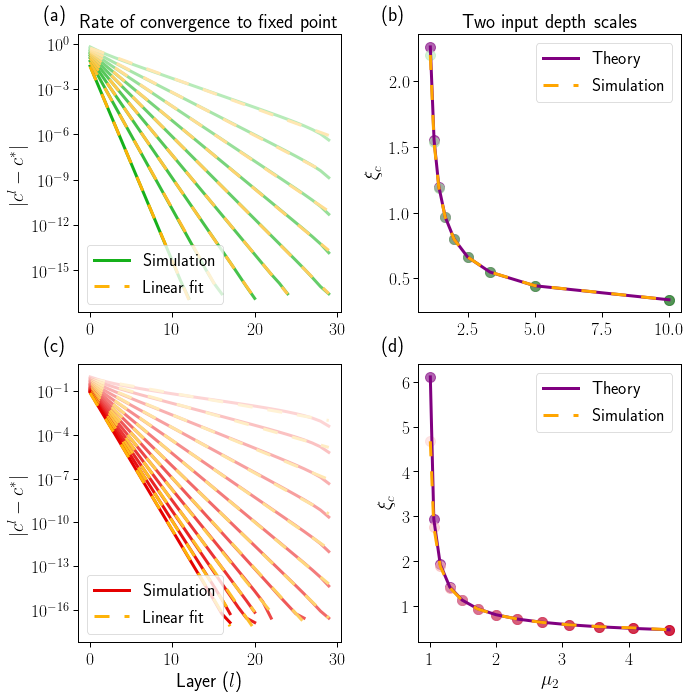

In [36]:
dropout_tests = [{
        "distributions": [{"dist": "bern", "prob_1": 0.1}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.2}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.3}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.4}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.5}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.7}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.8}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.9}],
        "activations": ["relu"],
        "inits": ["crit"]
    }]

gauss_tests = [{
        "distributions": [{"dist": "mult gauss", "std": 0.1}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.4}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.55}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.7}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.85}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.0}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.15}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.3}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.45}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.75}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 1.9}],
        "activations": ["relu"],
        "inits": ["crit"]
}]

fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
pal = get_colours(4, 13)
gs = plt.GridSpec(2, 2)
ax4 = plt.subplot(gs[0, 0])
ax5 = plt.subplot(gs[0, 1])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])

def plots(ax4, ax5, tests):
    cols_shades = []

    c_stars = []
    mu2s = []
    inferred_xi = [[], [], []]

    test_data = []
    for i, test in enumerate(tests):
        test_data.append(load_experiment(test, 
                                          ["multi_layer_cmap_sim", "cmap", "ctrajs", "chi1", "cmap_sim"], "results"))

    for i, (test, attr) in enumerate(zip(test_data, tests)):
        for dist in attr["distributions"]:
            if dist['dist'] == "none":
                col_i = 0
                shade_i = 6
            elif dist['dist'] == "bern":
                col_i = 1
                mu2s.append(1/float(dist['prob_1']))
                shade_i = int((10 - i)/10 * 12)

            elif "gauss" in dist['dist']:
                col_i = 3
                mu2s.append(float(dist['std'])**2 + 1)
                shade_i = i
            
            cols_shades.append([col_i, shade_i])

            for act in attr["activations"]:
                for init in attr["inits"]:
                    correlations = test[dist['dist']][act][init]['multi_layer_cmap_sim']
                    cmap_data = test[dist['dist']][act][init]['cmap']
                    cmaps = cmap_data["cmaps"]
                    cstars = cmap_data["cstars"]
                    ctrajs = test[dist['dist']][act][init]['ctrajs']
                    cmap_sim_data = test[dist['dist']][act][init]['cmap_sim']
                    cmap_sim_input = cmap_sim_data["input_correlations"]
                    cmap_sim_output = cmap_sim_data["output_correlations"]

                    # create label
                    label = ""

                    try:
                        label = "Gauss: $\sigma_\epsilon = $ " + str(dist['std'])
                    except:
                        try:
                            label = "Dropout: $p = $ " + str(dist['prob_1'])
                        except:
                            label = "No noise"

                    c_stars.append(correlations.mean(axis=-2).mean(axis=-2).mean(axis=0)[-1])

                    #############
                    # SEE HERE! #
                    #############

                    for i in range(3):
                        # plot rates of convergence
                        rates = np.abs(ctrajs[0, 0, i, :].T - ctrajs[0, 0, i, -1])

                        # mask zero values so that they don't break the plot
                        rates = np.ma.array(rates, mask=(rates == 0))

                        if i == 0:
                            if shade_i == 12:
                                label = "Simulation"
                            else:
                                label = ""
                                
                            ax4.plot(rates, c=pal[col_i][shade_i], linewidth=3.0, label=label)

                        # get a axis that corresponds to the non-zero elements
                        non_masked = np.array(np.ma.getmask(rates) ^ 1, dtype=bool)
                        x = np.arange(rates.shape[0])[non_masked]

                        z, b = np.polyfit(x, np.log(rates[x]), 1)
                        return_value = np.polyfit(x, np.log(rates[x]), 1)

                        if i == 0:
                            if shade_i == 12:
                                label = "Linear fit"
                            else:
                                label = ""
                                
                            ax4.plot(x, np.exp(x*z + b), c=pal[2][shade_i], linestyle="--", dashes=(5, 5), linewidth=3.0, label=label)

                        inferred_xi[i].append(-1/z)

    ###############
    # D SEE HERE! #
    ###############
    ax4.set_yscale('log')

    ###############
    # E SEE HERE! #
    ###############

    c_stars = np.array(c_stars)
    mu2s = np.array(mu2s)
    inferred_xi = np.array(inferred_xi).mean(axis=0)

    # compare theory depth scales with inferred ones from simulations
    xi_c = -1/np.log(np.arcsin(c_stars)/(np.pi*mu2s) + 1/(2*mu2s))

    for col_shade, mu2, xi, inf_xi in zip(cols_shades, mu2s, xi_c, inferred_xi):
        col = col_shade[0]
        shade = col_shade[1]
        ax5.plot(mu2, xi, 'ro', c='purple', alpha=0.6, markersize=10)
        ax5.plot(mu2, inf_xi, 'ro', c=pal[col][shade], alpha=0.6, markersize=10)

    mu2s_line = np.sort(mu2s)
    xi_c_line = np.flip(np.sort(xi_c), axis=0)
    inf_xi_line = np.flip(np.sort(inferred_xi))
    ax5.plot(mu2s_line, xi_c_line, label='Theory', c='purple', linewidth=3.0)
    ax5.plot(mu2s_line, inf_xi_line, linestyle='--', dashes=(5, 5), label='Simulation', c='orange', linewidth=3.0)

    ax4.legend(loc=3)
    ax5.legend()

plots(ax4=ax4, ax5=ax5, tests=dropout_tests)
plots(ax4=ax1, ax5=ax2, tests=gauss_tests)

ax4.set_ylabel(r'$|c^l - c^*|$')
ax1.set_ylabel(r'$|c^l - c^*|$')
ax1.set_xlabel('Layer ($l$)')
ax4.set_title('Rate of convergence to fixed point')
ax2.set_ylabel(r'$\xi_c$')
ax5.set_ylabel(r'$\xi_c$')
ax2.set_xlabel(r'$\mu_2$')
ax5.set_title("Two input depth scales")

##############
# add labels #
##############
fig.text(0.08, 0.96, "(a)")
fig.text(0.55, 0.96, "(b)")
fig.text(0.08, 0.5, "(c)")
fig.text(0.55, 0.5, "(d)")

# plt.savefig('corrplot.pdf', dpi=200)
# plt.show()
plt.gcf().tight_layout()
plt.savefig("xi.pdf")